### An introduction to `crunchy`

The following notebook provides an overview of typical usage for `crunchy`. In it, we construct a `crunchy` workflow using function decorators, launch a `crunchy` server for managing the real-time processing, and demonstrate that it works using some simple file operations.

This is loosely based around the tests implemented in `tests/test_dummy.py`.


### Step 1: Set up a `crunchy` workflow

Crunchy workflows are defined by decorated functions that get called whenever new files are discovered. This function can then choose to either (i) ignore the file, (ii) re-examine the file later (if more information is needed and expected), or (iii) trigger the execution of a chain of processing functions in a separate worker thread.

Note that for clarity we define this workflow here, while for most applications they would be defined in `crunchy/workflows/<myworkflow>.py`. As an example of this, see `crunchy/workflows/dummy.py`.

#### Settings

As a first step, we define some specific (customisable) settings for our workflow. These will be exposed (and thus editable) via the `crunchy` web interface. This is done by editing the `crunchy.workflow_settings` dictionary and filling it with arguments (keys) and dictionaries (values) that specify their data type, default value, limits and associated description.

In [1]:
import crunchy

# define custom settings that should be exposed through the GUI
crunchy.workflow_settings = dict(
    xdim = dict(type='int', value=512, min=256, max=4096, desc='a bounded integer. Represented in app by a slider.'),
    ydim = dict(type='int', value=512, min=256, max=4096, desc='another bounded integer'),
    noise = dict(type='float', value=3, min=1, max=10, desc='a bounded float. Represented in app by a slider.'),
    mode = dict(type='select', value='RGB', options=['RGB','RGBA','Greyscale'],desc=' a categorical string (dropdown box in app)'),
    format = dict(type='select', value='jpg', options=['png','bmp','jpg'],desc=''),
    name = dict(type='string', value='bigdata',desc='free text (a text box in app).'),
    set_count = dict(type='int', value=8, min=3, max=8,desc=''),
    assemble = dict(type='bool', value=True,desc='boolean variables (represented by check boxes in app).'),
    workflow_stage = dict( type='int', value=0, min=0, max=3,desc='staging variable for multi-step workflows.' ),
)

#### Initialisation

Next we can define a function that is called whenever a workflow is initialised (i.e. `crunchy` starts running). In this case we use this to set a few additional settings.

Note that the setup function is declared using the `@init` decorator, and takes three arguments - the input and output directories (that are set at run time via the web interface), and a dictionary containing all of the settings (including but not limited to the `workflow_settings` defined above).

In [2]:
from crunchy.base.trigger import init

# declare a setup function that is called when crunchy is launched
# N.B. be careful not to run this multiple times (in the notebook), or multiple init functions will be declared!
@init
def setup( indir, outdir, settings ):
    """

    This will be called after starting crunchy and before launching any worker threads. It is used here to setup
     hot directories (that are searched for files), and create some dummy input data.


    :param indir: a Path object to the input directory.
    :param outdir: a Path object to the output directory.
    :param settings: Workflow settings dictionary.
    :return: True if setup was successful (workflow should start), or False otherwise (workflow will be cancelled).
    """

    # create demo data in ouptut directory
    if 'set_count' not in settings:
        crunchy.log( "Error - invalid settings. Workflow cannot start.", crunchy.getLogDict() )
        return False

    set_count = settings['set_count']
    for j in range(3):
        o = '%s%d' % (settings['name'], j) # object name
        center = np.random.rand(2)
        for i in range(set_count):
            s = 'Set%d' % (i + 1)
            os.makedirs(indir / s / o, exist_ok=True)

            # create data files (containing random center pixels)
            np.save(indir / s / o / "point.npy", center + np.random.rand(2) * 0.01)

    # setup hot directories
    print("Building Input: ", indir)
    print("Output to: ", outdir)
    os.makedirs(outdir, exist_ok=True)
    crunchy.add(path = indir, depth=1, clear=False )
    crunchy.add(path = outdir, depth=0, clear=False )

    # progress to stage 1
    settings['workflow_stage'] = 1

    return True

#### Workflow

The following functions then define the core of our workflow functionality. In this trivial case it simply constructs some gaussian noise images and then combines them to get an average.

Note that each function in our workflow takes identical arguments:

- `data`: a dictionary that allows arbitrary data to be passed from one function to the next (in sequence).
- `outpath`: the directory into which any files should be written.
- `settings`: the settings dictionary as described above.

Arbitarily complex workflows can thus be broken down into piecewise chunks as needed. These are run in sequence within a single thread. More complex operations can also be defined by including multiple triggers that combine these in different ways (see next section).

In [3]:
import numpy as np
import os

In [4]:
def build_image( data, outpath, settings ):
    """
    Workflow functions should all take three arguments, as described below.

    :param data: A dictionary with data stored as keys. Data can be added or retrieved from this dictionary
                 to facilitate information sharing within different workflow steps (running in the same thread).
    :param outpath: A directory where any results should be written.
    :param settings: A dictionary of settings that can be modified / changed by the GUI. Use for e.g. customisable
                     arguments.
    :return: Anything returned by workflow functions will be ignored. Results should be written to files instead
             (as other methods for passing values between threads is slow and expensive).
    """

    # parse settings
    xdim = settings["xdim"]
    ydim = settings["ydim"]
    if 'Greyscale' in settings["mode"]:
        bands = 1
    elif 'RGB' in settings["mode"]:
        bands = 3
    elif 'RGBA' in settings["mode"]:
        bands = 4

    # initialise the array
    arr = np.zeros( (xdim,ydim,bands) )
    a = 5 + 5*np.random.rand() # random signal amplitude

    # load center pixel
    c = np.load(data['input'])
    cx = int(c[0] * xdim) # center of signal
    cy = int(c[1] * ydim) # center of signal

    # fill it with random numbers and a nice wave pattern
    # N.B. this is done with loops so as to be as sloow as possible ;-)
    for x in range(xdim):
        for y in range(ydim):

            # populate with signal (sign wave)
            r = np.sqrt( (x-cx)**2 + (y-cy)**2 )
            arr[x,y,:] = np.sin( 32 * r / xdim) * a**(-np.clip(r / xdim, 0.5, 1.0 ) )

    # store in data dictionary to make accessible to other functions
    data['image'] = arr

def add_noise( data, outpath, settings ):
    sigma = settings['noise']
    arr = data['image']
    noise = np.zeros_like(arr)
    for x in range(arr.shape[0]):
        for y in range(arr.shape[1]):
            for z in range(arr.shape[2]):
                noise[x,y,z] = np.random.rand()*sigma
                arr[x,y,z] += noise[x,y,z]

    # write noisy image to output directory
    fname = "%s_%d.image.npy" % (data['name'], os.getpid())
    np.save( outpath / fname, arr )

def save_image( data, outpath, settings ):
    fmt = settings['format']
    name = data['name']
    arr = data['image']

    # normalise to range 0 - 255 and cast to uint8
    mn, mx = np.percentile(arr, (1, 99))
    arr = (np.clip((arr - mn) / (mx - mn), 0, 1) * 255).astype(np.uint8)

    if arr.shape[-1] == 1:
        arr = np.dstack([ arr[...,0], arr[...,0], arr[...,0] ] )

    # write image
    fname = "%s.image.%s" % (name, fmt)

    from PIL import Image # try importing PIL. This will fail if not installed
    image = Image.fromarray(arr)
    image.save(outpath / fname)

def average( data, outpath, settings ):
    # load data
    assert 'files' in data, "Error - files must be specified."
    arr = np.array( [np.load(str(f))for f in data['files'] ] )
    settings['workflow_stage'] = 2  # upgrade workflow stage (just to test settings can be modified)
    # average it
    data['image'] = np.mean(arr, axis=0 )

#### Triggers

And finally we define entry points that trigger the workflow execution. The simplest of these is a file filter,
which checks files or directories picked up by crunchy.scout. If yes, it should return `trigger.PROCESS` and each of the functions defined in the `flow` argument of the decorator (which must take a list of functions that accept `data`, `outpath` and `settings` arguments) will be run in sequence in a parallel worker thread.

This function also has the chance to set up the data dictionary for this workflow, and/or update
the settings dictionary if required. It takes three arguments, which match the arguments of each workflow function described in the previous section. Note that by default the `data` dictionary contains a `path` key of the new file or folder being checked. 

Note (as already mentioned) that the function decorator that actually setups up the workflow sequence. This allows workflow functions to be set up in different combinations or orders for different entry points. 

In [5]:
from crunchy.base import trigger
from crunchy.base.trigger import fileTrigger

# create a new file trigger.
# N.B. be careful not to run this multiple times in a notebook, or ever file will be processed several times!
@fileTrigger(flow = [build_image, add_noise, save_image], fail=crunchy.base.errors.logAndStop, vb=3)
def process( data, outpath, settings ):
    #print(data['path'], os.path.exists(data['path']))
    path = data['path'] # this is the path being checked
    if os.path.exists(path / 'point.npy' ):

        # get file properties
        data['input'] = path / 'point.npy'
        data['name'] = path.parent.name

        # trigger processing and specify target directory for output
        return trigger.PROCESS, outpath / os.path.basename( path )

    # reject this folder
    return trigger.REJECT, ''

To highlight the non-linearity that can be achieved by combining triggers, we also add a second file filter which, once the noise-added images have been created by each of the spawned worker threads, picks up the directory again and averages them together. This demonstrates how file filters can also be used to perform assembly steps on results.

In [6]:
@fileTrigger(flow = [average, save_image], fail=crunchy.base.errors.logAndStop, vb=3)
def assemble( data, outpath, settings ):
    files = list( data['path'].glob("*.image.npy"))
    comp = list( data['path'].glob("comp.image.png"))

    if settings['assemble']:
        if len(files) == settings['set_count']: # check all preprocessing has been done
            if len(comp) == 0: # check average hasn't already been created
                data['files'] = files # store list of files to average
                data['name'] ='comp' # output file name
                settings['format'] = 'png' # force output format to be png
                return trigger.PROCESS, data['path'] # output directory in same spot as input
    return trigger.REJECT, ''

Lastly, we can also add a trigger that is called only once all running jobs have been finished and the user has clicked `finish` in the GUI. We don't do anything useful in this case, but theoreticaly could do!

In [7]:
from crunchy.base.trigger import finish
@finish
def final_tasks( indir, outdir, settings ):
    """
    This will be run when all jobs are completed.
    """
    print("A job well done!")

### Step 2: Launch crunchy in headless mode

Now that we have an (entirely useless but hopefully educational) workflow setup, we can go ahead and launch crunchy. First, we do this in headless mode (i.e. without running a HTTP server to allow manual control).

Note that this will not block this thread, but that outputs (message logs) should start to appear in the output of the cell below as different jobs are spawned and completed.

In [8]:
# initialise crunchy and spawn seven worker threads
crunchy.init(7) 

# programmatically change a few settings
crunchy.settings['wait'] = 2  # how many times to visit a file before passing it to the workflow (to check stable size)
crunchy.settings['idle'] = 0.1  # how long to sleep between checks

# programmatically set the output directory
import os
from pathlib import Path
crunchy.setOutpath( Path(os.getcwd() ) / 'CrunchyOut' )

# launch crunchy. This starts our worker threads and also a CrunchyScout thread that starts to look for new files.
crunchy.run()

[00:32:00][53335] Worker initialised.
[00:32:00][53336] Worker initialised.
[00:32:00][53337] Worker initialised.
[00:32:00][53338] Worker initialised.
[00:32:00][53339] Worker initialised.
[00:32:00][53340] Worker initialised.
[00:32:00][53341] Worker initialised.
Building Input:  CrunchyIn
Output to:  /Users/thiele67/Documents/Python/Public/crunchy/CrunchyOut


<Process name='Process-10' pid=53343 parent=53328 started>

[00:32:00][53343] Spawning control thread..
[00:32:11][53343] Filtering CrunchyIn/Set2/bigdata2 with process.
[00:32:11][53343] Queuing job for: CrunchyIn/Set2/bigdata2.
[00:32:11][53343] Filtering CrunchyIn/Set2/bigdata2 with assemble.
[00:32:11][53336] Running build_image on CrunchyIn/Set2/bigdata2.
[00:32:11][53343] Filtering CrunchyIn/Set2/bigdata0 with process.
[00:32:11][53343] Queuing job for: CrunchyIn/Set2/bigdata0.
[00:32:11][53343] Filtering CrunchyIn/Set2/bigdata0 with assemble.
[00:32:11][53340] Running build_image on CrunchyIn/Set2/bigdata0.
[00:32:11][53343] Filtering CrunchyIn/Set2/bigdata1 with process.
[00:32:11][53343] Queuing job for: CrunchyIn/Set2/bigdata1.
[00:32:11][53343] Filtering CrunchyIn/Set2/bigdata1 with assemble.
[00:32:11][53335] Running build_image on CrunchyIn/Set2/bigdata1.
[00:32:11][53343] Filtering CrunchyIn/Set5/bigdata2 with process.
[00:32:11][53343] Queuing job for: CrunchyIn/Set5/bigdata2.
[00:32:11][53343] Filtering CrunchyIn/Set5/bigdata2 w

In [9]:
# wait until queue is empty and then end
import time
time.sleep(60.) # make sure we run for a little while
crunchy.complete()

[00:33:00][53328] Running final tasks: [final_tasks].
A job well done!


### Step 3: Launch crunchy with a HTTP server

While running `crunchy` as shown above can be very useful, in many situations it is useful to be able to (1) interactively adjust the crunchy and/or workflow-specific settings, and (2) have a nicer control interface to see what each worker thread is doing. For this, we can launch a crunchy HTTP server.

In [10]:
from crunchy.app import run

In [11]:
# run a HTTP crunchy server, using our current directory as the base
run(os.getcwd()) # easy as that!!

 * Serving Flask app 'crunchy.app'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5001
 * Running on http://127.0.0.1:5001
Press CTRL+C to quit
127.0.0.1 - - [02/Jul/2024 00:34:00] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [02/Jul/2024 00:34:00] "GET /static/style.css HTTP/1.1" 304 -
127.0.0.1 - - [02/Jul/2024 00:34:00] "GET /static/icon_64.png HTTP/1.1" 304 -


Clicking the link above (usually [http://127.0.0.1:5001](http://127.0.0.1:5001)) should take you to a settings page showing all of the default `crunchy` settings and defined workflow-specific ones. 

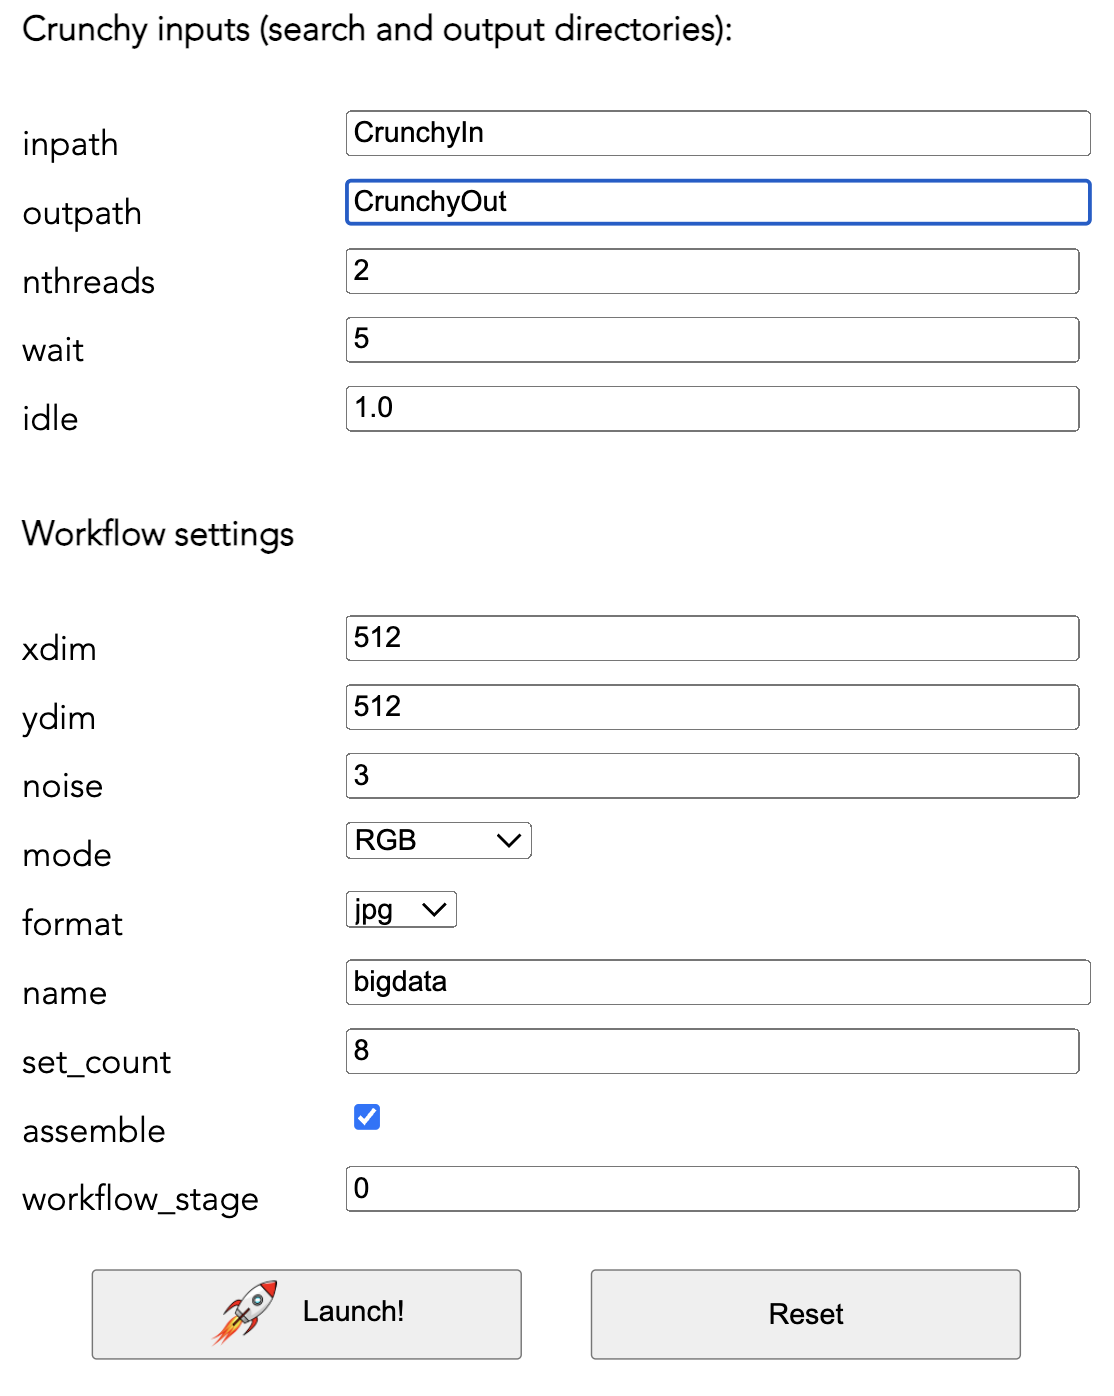



After clicking "Launch", `crunchy` should start crunching and a monitoring / control window should display instead. Note that by default crunchy requires the `CrunchyIn` directory to already exist - so you may need to create this before it will correctly launch.

This monitoring window (shown below) contains:

1. Buttons for pausing, finishing (i.e. waiting untill all currently launched jobs are finished and then ending) or terminating (brutally killing the worker threads).
2. A *Queue info* list showing jobs files currently being run through workflows in the worker threads.
3. A *Scout info* panel showing locations where `CrunchyScout` is searching for new files and the number of files being monitored.
4. A master log showing important `crunchy` events.
5. A set of logs for each of the worker threads showing messages (or errors) from each specific workflow.
6. Lastly, at the bottom of the window, a list of all the files that have already been processed is displayed.

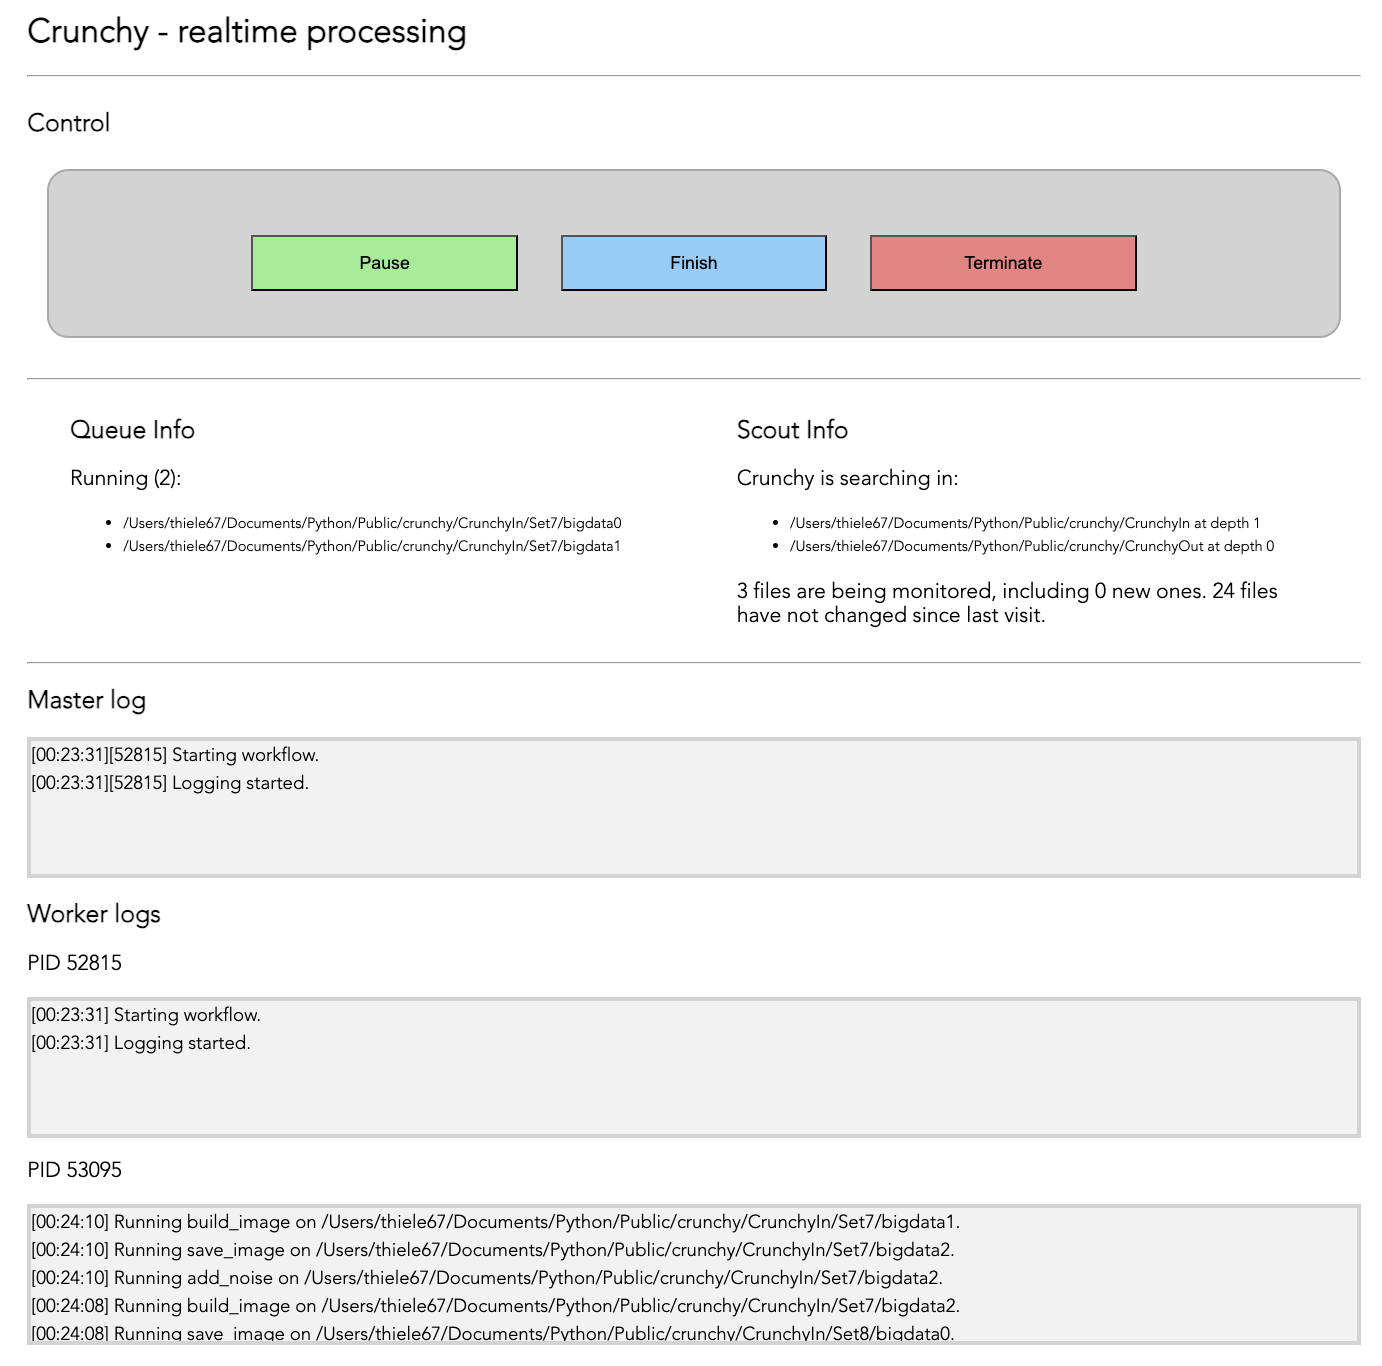

And that's it! I hope this run-through helps explain how to use the `crunchy` framework to build workflows for arbitarily complex processing workflows and file-based trigger functions, and how to use the HTTP server to setup, launch and manage these.

Happy crunching! :-)


### P.S. Cleanup

Lastly, we clean-up (delete) the test files we just created. It isn't easy being clean!

In [13]:
import shutil
import os
from pathlib import Path

if os.path.exists( Path(os.getcwd() ) / 'CrunchyOut' ):
    shutil.rmtree( Path(os.getcwd() ) / 'CrunchyOut' )  # delete CrunchyOut directory
if os.path.exists( Path(os.getcwd() ) / 'CrunchyIn' ):
    shutil.rmtree( Path(os.getcwd() ) / 'CrunchyIn' )  # delete CrunchyIn directory